In [23]:
import numpy as np
from astropy.modeling.models import Sersic1D, Sersic2D
import matplotlib.pyplot as plt
from astropy.visualization import hist

In [2]:
def randomvariate(pdf, n, xmin, xmax):
    """
    Create random numbers according to an arbitrary PDF
    Uses the rejection method for generating random numbers derived from an arbitrary   
    probability distribution. For reference, see Bevington's book, page 84. Based on  
    rejection*.py.
    Usage:  
    >>> randomvariate(P,N,xmin,xmax)  
    where  
    P : probability distribution function from which you want to generate random numbers  
    N : desired number of random values  
    xmin,xmax : range of random numbers desired  
    
    Returns:   
    the sequence (ran,ntrials) where  
    ran : array of shape N with the random variates that follow the input P  
    ntrials : number of trials the code needed to achieve N  
   
    Here is the algorithm:  
    - generate x' in the desired range  
    - generate y' between Pmin and Pmax (Pmax is the maximal value of your pdf)  
    - if y'<P(x') accept x', otherwise reject  
    - repeat until desired number is achieved  
   
    Rodrigo Nemmen  
    Nov. 2011  
    """
    x = np.linspace(xmin, xmax, 10000)
    y = pdf(x)
    pmin = y.min()
    pmax = y.max()
    naccept = 0
    ntrial = 0
    ran = []
    while naccept < n:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(pmin, pmax)
        if y <= pdf(x):
            ran.append(x)
            naccept = naccept+1
                #  print pdf(x)
            ntrial = ntrial + 1

    ran = np.asarray(ran)
    return ran, ntrial
    

In [50]:
def rvs(pdf, n, xmin, xmax):
    """
    Create random numbers according to an arbitrary PDF
    Uses the rejection method for generating random numbers derived from an arbitrary   
    probability distribution. For reference, see Bevington's book, page 84. Based on  
    rejection*.py.
    Usage:  
    >>> randomvariate(P,N,xmin,xmax)  
    where  
    P : probability distribution function from which you want to generate random numbers  
    N : desired number of random values  
    xmin,xmax : range of random numbers desired  
    
    Returns:   
    the sequence (ran,ntrials) where  
    ran : array of shape N with the random variates that follow the input P  
    ntrials : number of trials the code needed to achieve N  
   
    Here is the algorithm:  
    - generate x' in the desired range  
    - generate y' between Pmin and Pmax (Pmax is the maximal value of your pdf)  
    - if y'<P(x') accept x', otherwise reject  
    - repeat until desired number is achieved  
   
    Rodrigo Nemmen  
    Nov. 2011  
    """
    x = np.linspace(xmin, xmax, 1e9)
    y = pdf(x)
    pmin = y.min()
    pmax = y.max()
    naccept = 0
    ntrial = 0
    ran = []
    X = np.random.uniform(xmin, xmax, len(x))
    Y = np.random.uniform(pmin, pmax, len(x))
    ran = X[Y<=pdf(X)]
    return ran[:n]

100

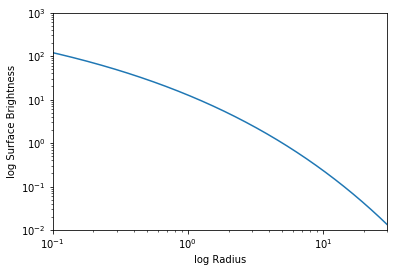

In [8]:
plt.figure()
plt.subplot(111, xscale='log', yscale='log')
s1 = Sersic1D(amplitude=1, r_eff=5, n=4)
r=np.arange(0, 100, .01)

plt.plot(r, s1(r))

plt.axis([1e-1, 30, 1e-2, 1e3])
plt.xlabel('log Radius')
plt.ylabel('log Surface Brightness')
#plt.text(.25, 1.5, 'n=1')
#plt.text(.25, 300, 'n=10')
#plt.xticks([])
#plt.yticks([])
plt.show()

In [43]:
ran, ntrial = randomvariate(s1, 1000, xmin=0, xmax=10)

In [ ]:
ran = rvs(s1, 1000, xmin=0, xmax=10)

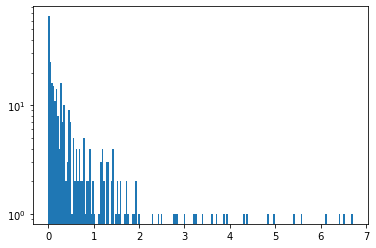

In [47]:

hist(ran, bins=200)
plt.semilogy()
plt.show()

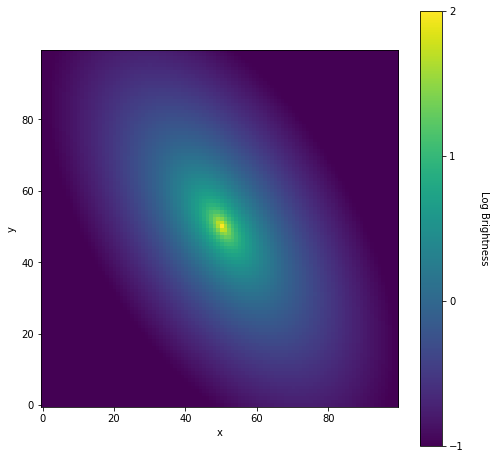

In [24]:
x,y = np.meshgrid(np.arange(100), np.arange(100))

mod = Sersic2D(amplitude = 1, r_eff = 25, n=4, x_0=50, y_0=50,
               ellip=.5, theta=-1)
img = mod(x, y)
log_img = np.log10(img)

plt.figure(figsize=(8,8))
plt.imshow(log_img, origin='lower', interpolation='nearest',
           vmin=-1, vmax=2)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

TypeError: __call__() missing 1 required positional argument: 'y'